# Model Training and Evaluation Notebook

In [1]:
# imports
import pandas as pd
import numpy as np
import mlflow
from mlflow.models.signature import infer_signature
from scipy.sparse import vstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import sent_tokenize
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', None)

### Data Loading

In [2]:
def count_vec(vec_params, df_all, df_train, df_test):
    #Count Vectorizer:
    vectorizer1 = CountVectorizer(**vec_params) #initialise the vectorizer
    vectorizer1.fit(df_all['sentence'].tolist()) #fit vectorizer to entire corpus

    # vectorize test and train separately
    df_train['count_vector'] = df_train.apply(lambda x: vectorizer1.transform([x['sentence']]), axis=1)
    df_test['count_vector'] = df_test.apply(lambda x: vectorizer1.transform([x['sentence']]), axis=1)
    
    return df_train, df_test, vectorizer1

In [3]:
def tfidf_vec(vec_params, df_all, df_train, df_test):
    # TF-IDF Vectorizer:
    vectorizer2 = TfidfVectorizer(**vec_params) #initialise the vectorizer
    vectorizer2.fit(df_all['sentence'].tolist()) #fit vectorizer to entire corpus

    # vectorize test and train separately
    df_train['tf_idf_vector'] = df_train.apply(lambda x: vectorizer2.transform([x['sentence']]), axis=1)
    df_test['tf_idf_vector'] = df_test.apply(lambda x: vectorizer2.transform([x['sentence']]), axis=1)
    
    return df_train, df_test, vectorizer2

Pull out the data from the df and save in numpy vectors for easy use with SKLearn:

In [4]:
def data_vec(vec, vec_params):
    
    df_all = pd.read_csv('./data/all.csv')
    df_train = pd.read_csv('./data/train.csv')
    df_test = pd.read_csv('./data/test.csv')
    
    Y_train = df_train['avg_score'].to_numpy()
    Y_test = df_test['avg_score'].to_numpy()
    
    if vec=='count':
        df_train, df_test, vectorizer = count_vec(vec_params, df_all, df_train, df_test)
        X_train = vstack(df_train['count_vector'].to_numpy())
        X_test = vstack(df_test['count_vector'].to_numpy())
    elif vec=='tfidf':
        df_train, df_test, vectorizer = tfidf_vec(vec_params, df_all, df_train, df_test)
        X_train = vstack(df_train['tf_idf_vector'].to_numpy())
        X_test = vstack(df_test['tf_idf_vector'].to_numpy())
    else:
        raise ValueError('Vectorizer not chosen')
        
    return X_train, X_test, Y_train, Y_test, vectorizer

### MLflow Setup

- Please run the CLI commands in the 010-MLflow-setup notebook to initiate the MLflow server.
- The MLflow UI can be accessed [here](http://127.0.0.1:5000).

In [5]:
tracking_uri = "http://127.0.0.1:5000/"
mlflow.set_tracking_uri(tracking_uri)

## Models experimented with:
1. Linear Regression
2. Ridge Regression (L2 regularization)
3. Lasso Regression (L1 regularization)
4. ElasticNet Regression (L1 and L2 priors as regularizer)
5. Bayesian Ridge Regression (This is not work as the model implementation does not accept sparse vectors)

### 1. Linear Regression

In [6]:
# create new experiment with MLflow:
experiment_name = "linear_regression"
mlflow.set_experiment(experiment_name);
# enable autologging
# this auto logs model, model parameters and traning metrics
mlflow.sklearn.autolog()

Let's set some vectorizer and model parameters:

In [7]:
vectorizer = 'count' # count or tfidf
vec_params = {
    'lowercase' : True, #Convert all characters to lowercase before tokenizing
    'stop_words': 'english', #Use sklearn built in corpus for stop word removal
    'max_df': 1.0, #maximum document frequency: we can ignore words which occur frequently
    'min_df': 0.00, #minimum document frequency: we can ignore words which occur infrequently
    'analyzer' : 'word', #tokenize to words
    'ngram_range': (1,1),
}

model_params = {
    
}

In [8]:
with mlflow.start_run() as run:
    # log non-model parameters in Mlflow:
    mlflow.log_param("vectorizer", vectorizer)
    mlflow.log_params(vec_params)
    
    # data
    X_train, X_test, Y_train, Y_test, vectorizer = data_vec(vectorizer, vec_params)
    # number of features
    num_features = vectorizer.get_feature_names_out().shape[0]
    print("Number of Features: ", num_features)
    mlflow.log_metric("number_of_features", num_features)
    
    # train
    lin_reg_model = linear_model.LinearRegression(**model_params)
    lin_reg_model.fit(X_train, Y_train)
    
    # evaluate on test set
    Y_pred = lin_reg_model.predict(X_test)
    r2score = r2_score(Y_test, Y_pred)
    MSE = mean_squared_error(Y_test, Y_pred)
    print("Test R2 score : %.3f" % r2score)
    print("Test Mean squared error: %.3f" % MSE)
    
    # log test metrics
    mlflow.log_metric("test_r2_score", r2score)
    mlflow.log_metric("test_mse", MSE)

Number of Features:  17324


2022/12/01 17:06:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/miniconda3/envs/sprint-py/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


Test R2 score : -7.522
Test Mean squared error: 14.950


### 2. Ridge Regression

In [9]:
# create new experiment with MLflow:
experiment_name = "ridge_regression"
mlflow.set_experiment(experiment_name);
# enable autologging
# this auto logs model, model parameters and traning metrics
mlflow.sklearn.autolog()

Let's set some vectorizer and model parameters:

In [10]:
vectorizer = 'count' # count or tfidf
vec_params = {
    'lowercase' : True, #Convert all characters to lowercase before tokenizing
    'stop_words': 'english', #Use sklearn built in corpus for stop word removal
    'max_df': 1.0, #maximum document frequency: we can ignore words which occur frequently
    'min_df': 0.0, #minimum document frequency: we can ignore words which occur infrequently
    'analyzer' : 'word', #tokenize to words
    'ngram_range': (1,1),
}

model_params = {
    'alpha': 1.0
    
}

In [11]:
with mlflow.start_run() as run:
    # log parameters in Mlflow:
    mlflow.log_param("vectorizer", vectorizer)
    mlflow.log_params(vec_params)
    
    # data
    X_train, X_test, Y_train, Y_test, vectorizer = data_vec(vectorizer, vec_params)
    # number of features
    num_features = vectorizer.get_feature_names_out().shape[0]
    print("Number of Features: ", num_features)
    mlflow.log_metric("number_of_features", num_features)
    
    # train
    ridge_reg_model = linear_model.Ridge(**model_params)
    ridge_reg_model.fit(X_train, Y_train)
    
    # evaluate on test set
    Y_pred_ridge = ridge_reg_model.predict(X_test)
    r2score = r2_score(Y_test, Y_pred)
    MSE = mean_squared_error(Y_test, Y_pred)
    print("Test R2 score : %.3f" % r2score)
    print("Test Mean squared error: %.3f" % MSE)
    
    # log test metrics
    mlflow.log_metric("test_r2_score", r2score)
    mlflow.log_metric("test_mse", MSE)

Number of Features:  17324
Test R2 score : -7.522
Test Mean squared error: 14.950


### 3. Lasso Regression

In [12]:
# create new experiment with MLflow:
experiment_name = "lasso_regression"
mlflow.set_experiment(experiment_name);
# enable autologging
# this auto logs model, model parameters and traning metrics
mlflow.sklearn.autolog()

Let's set some vectorizer and model parameters:

In [13]:
vectorizer = 'count' # count or tfidf
vec_params = {
    'lowercase' : True, #Convert all characters to lowercase before tokenizing
    'stop_words': 'english', #Use sklearn built in corpus for stop word removal
    'max_df': 1.0, #maximum document frequency: we can ignore words which occur frequently
    'min_df': 0.00, #minimum document frequency: we can ignore words which occur infrequently
    'analyzer' : 'word', #tokenize to words
    'ngram_range': (1,1),
}

model_params = {
    'alpha': 0.05 
}

In [14]:
with mlflow.start_run() as run:
    # log parameters in Mlflow:
    mlflow.log_param("vectorizer", vectorizer)
    mlflow.log_params(vec_params)
    
    # data
    X_train, X_test, Y_train, Y_test, vectorizer = data_vec(vectorizer, vec_params)
    # number of features
    num_features = vectorizer.get_feature_names_out().shape[0]
    print("Number of Features: ", num_features)
    mlflow.log_metric("number_of_features", num_features)
    
    # train
    lasso_reg_model = linear_model.Lasso(**model_params)
    lasso_reg_model.fit(X_train, Y_train)
    
    # evaluate on test set
    Y_pred = lasso_reg_model.predict(X_test)
    r2score = r2_score(Y_test, Y_pred_ridge)
    MSE = mean_squared_error(Y_test, Y_pred_ridge)
    print("Test R2 score : %.3f" % r2score)
    print("Test Mean squared error: %.3f" % MSE)
    
    # log test metrics
    mlflow.log_metric("test_r2_score", r2score)
    mlflow.log_metric("test_mse", MSE)

Number of Features:  17324
Test R2 score : 0.191
Test Mean squared error: 1.419


### 4. ElasticNet Regression

In [15]:
# create new experiment with MLflow:
experiment_name = "elasticnet_regression"
mlflow.set_experiment(experiment_name);
# enable autologging
# this auto logs model, model parameters and traning metrics
mlflow.sklearn.autolog()

Let's set some vectorizer and model parameters:

In [16]:
vectorizer = 'count' # count or tfidf
vec_params = {
    'lowercase' : True, #Convert all characters to lowercase before tokenizing
    'stop_words': 'english', #Use sklearn built in corpus for stop word removal
    'max_df': 1.0, #maximum document frequency: we can ignore words which occur frequently
    'min_df': 0.00, #minimum document frequency: we can ignore words which occur infrequently
    'analyzer' : 'word', #tokenize to words
    'ngram_range': (1,1),
}

model_params = {
    'alpha': 1.0,
    'l1_ratio': 0.01
}

In [17]:
with mlflow.start_run() as run:
    # log parameters in Mlflow:
    mlflow.log_param("vectorizer", vectorizer)
    mlflow.log_params(vec_params)
    
    # data
    X_train, X_test, Y_train, Y_test, vectorizer = data_vec(vectorizer, vec_params)
    # number of features
    num_features = vectorizer.get_feature_names_out().shape[0]
    print("Number of Features: ", num_features)
    mlflow.log_metric("number_of_features", num_features)
    
    # train
    elasticnet_model = linear_model.ElasticNet(**model_params)
    elasticnet_model.fit(X_train, Y_train)
    
    # evaluate on test set
    Y_pred = elasticnet_model.predict(X_test)
    r2score = r2_score(Y_test, Y_pred)
    MSE = mean_squared_error(Y_test, Y_pred)
    print("Test R2 score : %.3f" % r2score)
    print("Test Mean squared error: %.3f" % MSE)
    
    # log test metrics
    mlflow.log_metric("test_r2_score", r2score)
    mlflow.log_metric("test_mse", MSE)

Number of Features:  17324
Test R2 score : 0.003
Test Mean squared error: 1.748


As we can see, Ridge Regression is a clear winner, let's set-up inference to see how it performs on the 'sanity-check' job descriptions.

## Inference
The final deployment will take paragraphs as input compared to sentences in the traning data, therefore to sentence boundary detection will be used to split the text into sentences and each one fed into the model in series.

### Let's load the 'sanity check' job descriptions that were created in the 001-data-ingest notebook:

In [18]:
f = open("./data/sanity_check/formal_text.txt", "r")
formal = f.read()
f.close()
print(formal)

As a Trainee Artificial Intelligence (AI) Engineer in Kainos, you’ll be responsible for contributing to the development of high-quality solutions which integrate AI and ML technologies that delight our customers and impact the lives of users worldwide. You’ll do this whilst gaining awareness and learning about new AI technologies, frameworks and approaches, with talented colleagues that will help you to learn, develop and grow.


In [19]:
f = open("./data/sanity_check/informal_text.txt", "r")
informal = f.read()
f.close()
print(informal)

A Trainee AI engineering at kainos will be building good solutions that join AI and ML stuff that make customers really happy and people everywhere. Need to learn about all new stuff in AI and talk loads with people you work with to get smarter and do more stuff.


### Sentence Tokenization

In [20]:
print('1st Sentence: ', sent_tokenize(formal)[0])
print('\n')
print('2nd Sentence: ', sent_tokenize(formal)[1])

1st Sentence:  As a Trainee Artificial Intelligence (AI) Engineer in Kainos, you’ll be responsible for contributing to the development of high-quality solutions which integrate AI and ML technologies that delight our customers and impact the lives of users worldwide.


2nd Sentence:  You’ll do this whilst gaining awareness and learning about new AI technologies, frameworks and approaches, with talented colleagues that will help you to learn, develop and grow.


### Inference pipeline

In [21]:
def inferece(text_input, vectorizer, model):
    sentences = sent_tokenize(text_input)
    vectors = vectorizer.transform(sentences)
    scores = model.predict(vectors).round(2)
    sentence_formality_df = pd.DataFrame(np.column_stack([sentences, scores]), columns = ['Sentence', 'Formality Score'])
    sentence_formality_df['Formality Score'] = pd.to_numeric(sentence_formality_df['Formality Score'])
    sentence_formality_df.loc[sentence_formality_df['Formality Score'] < 0, 'Formality'] = 'Informal'
    sentence_formality_df.loc[sentence_formality_df['Formality Score'] > 0, 'Formality'] = 'Formal'
    return sentence_formality_df

#### Informal test:

In [22]:
sentence_formality_df = inferece(informal, vectorizer, ridge_reg_model)
display(sentence_formality_df)
print("Average formality score: ", sentence_formality_df['Formality Score'].mean())

,Sentence,Formality Score,Formality
0,A Trainee AI engineering at kainos will be building good solutions that join AI and ML stuff that make customers really happy and people everywhere.,-0.17,Informal
1,Need to learn about all new stuff in AI and talk loads with people you work with to get smarter and do more stuff.,-0.44,Informal


Average formality score:  -0.305


✅ Correct Classification!

#### Formal test:

In [23]:
sentence_formality_df = inferece(formal, vectorizer, ridge_reg_model)
display(sentence_formality_df)
print("Average formality score: ", sentence_formality_df['Formality Score'].mean())

,Sentence,Formality Score,Formality
0,"As a Trainee Artificial Intelligence (AI) Engineer in Kainos, you’ll be responsible for contributing to the development of high-quality solutions which integrate AI and ML technologies that delight our customers and impact the lives of users worldwide.",1.48,Formal
1,"You’ll do this whilst gaining awareness and learning about new AI technologies, frameworks and approaches, with talented colleagues that will help you to learn, develop and grow.",1.62,Formal


Average formality score:  1.55


✅ Correct Classification!

#### Test on an actual Job Description:

In [24]:
job_desc = "As a Lead Software Engineer (Consultant) in Kainos, you’ll be responsible for leading teams and developing high quality solutions which delight our customers and impact the lives of users worldwide. It’s a fast-paced environment so it is important for you to make sound, reasoned decisions. You’ll do this whilst learning about new technologies and approaches, with talented colleagues that will help you to learn, develop and grow. You’ll manage, coach and develop a small number of staff, with a focus on managing employee performance and assisting in their career development. You’ll also provide direction and leadership for your team as you solve challenging problems together.  As the technical leader in the team, you will also interact with customers, share knowledge and mentor those around you. Expertise in designing, building, testing and maintaining modern software applications. Technical leadership of teams building and testing modern, scalable, secure, performant applications in line with software development principles, practices and patterns. Experience of technical ownership for a product/software project, including architecture, estimation, product planning and user story/requirement creation. Expertise in software design and development across all layers of an application. We are passionate about developing people – a demonstrated ability in managing, coaching and developing junior members of your team and wider community. Experience with the latest Continuous Integration and Continuous Delivery techniques. Good communication skills, with the ability to communicate issues to technical and non-technical people. Active participation in knowledge sharing activities, both within the team and at a wider capability level and externally where appropriate. Experience of debugging and troubleshooting live applications. Experience of multiple programming languages and data storage technologies. Knowledge of public cloud platforms, such as AWS and Azure, including SaaS and PaaS offerings. Our vision is to enable outstanding people to create digital solutions that have a positive impact on people’s lives. Our values aren't abstract; they are the behaviours we expect from each other every day and underpin everything that we do. We expect everyone to display our values by being determined in how obstacles are overcome; honest when dealing with others; respectful of how you treat others; creative to find solutions to complex problems and cooperative by sharing information, knowledge and experience. These values, applied collectively, help to produce an outstanding Kainos person, team and culture. At Kainos we use technology to solve real problems for our customers, overcome big challenges for businesses, and make people’s lives easier. We build strong relationships with our customers and go beyond to change the way they work today and the impact they have tomorrow. Our two specialist practices, Digital Services and Workday, work globally for clients across healthcare, commercial and the public sector to make the world a little bit better, day by day. For more information, see kainos.com"

In [25]:
sentence_formality_df = inferece(job_desc, vectorizer, ridge_reg_model)
display(sentence_formality_df)
print("Average formality score: ", sentence_formality_df['Formality Score'].mean())

,Sentence,Formality Score,Formality
0,"As a Lead Software Engineer (Consultant) in Kainos, you’ll be responsible for leading teams and developing high quality solutions which delight our customers and impact the lives of users worldwide.",1.67,Formal
1,"It’s a fast-paced environment so it is important for you to make sound, reasoned decisions.",0.56,Formal
2,"You’ll do this whilst learning about new technologies and approaches, with talented colleagues that will help you to learn, develop and grow.",0.72,Formal
3,"You’ll manage, coach and develop a small number of staff, with a focus on managing employee performance and assisting in their career development.",2.07,Formal
4,You’ll also provide direction and leadership for your team as you solve challenging problems together.,-0.35,Informal
5,"As the technical leader in the team, you will also interact with customers, share knowledge and mentor those around you.",0.05,Formal
6,"Expertise in designing, building, testing and maintaining modern software applications.",0.54,Formal
7,"Technical leadership of teams building and testing modern, scalable, secure, performant applications in line with software development principles, practices and patterns.",3.10,Formal
8,"Experience of technical ownership for a product/software project, including architecture, estimation, product planning and user story/requirement creation.",2.49,Formal
9,Expertise in software design and development across all layers of an application.,0.70,Formal


Average formality score:  0.6856


# Evaluation Visualizations

In [26]:
# load the test data and add model predictions to the dataframe
df_test = pd.read_csv('./data/test.csv')
df_test['predictions'] = Y_pred_ridge.tolist()
df_test.head(3)

,domain,avg_score,sentence,predictions
0,news,1.00,"Saleh said the detainees told interrogators the attackers came from Pakistan's Swat Valley and that the al-Qaida mastermind fled across the border into Pakistan's lawless tribal area, where the al-Qaida leadership is believed hiding.",1.496848
1,answers,-2.25,"i own this board, now.",-0.546559
2,answers,-2.00,will lead you into blind alleys.,-0.421635


#### Scatter Plot: Ground Truth vs Model Predictions

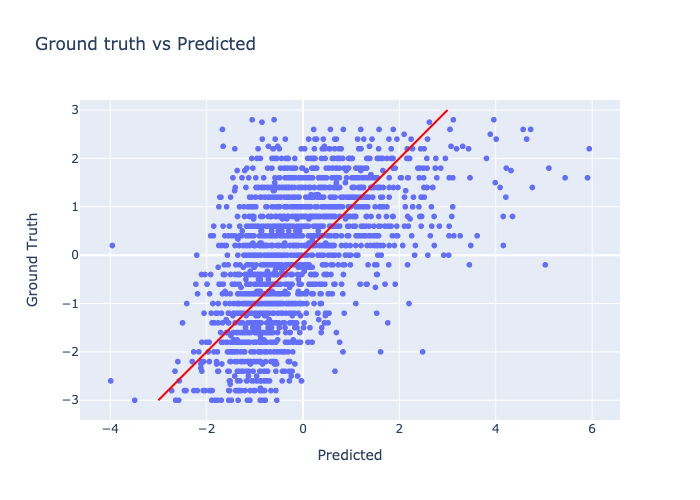

In [27]:
fig = px.scatter(df_test, x = 'predictions', y = 'avg_score',
                labels={'predictions':'Predicted', 'avg_score':'Ground Truth'},
                title="Ground truth vs Predicted"
                )
fig.add_shape(type='line',
                x0=-3,
                y0=-3,
                x1=3,
                y1=3,
                line=dict(color='Red',),
                xref='x',
                yref='y'
)
fig.show("png")

## Which features of the model contribute the most to the formality score?

In [28]:
features = vectorizer.get_feature_names_out()
ascending_ind = np.argsort(ridge_reg_model.coef_)

10 most informal words:

In [29]:
print(features[ascending_ind[:10]])

['ur' 'wtf' 'lol' 'jus' 'yup' 'raymond' 'dana' 'moron' 'ppl' 'stupidest']


10 most formal words:

In [30]:
print(features[ascending_ind[-10:]])

['branker' 'unfortunate' 'rhonnie' 'correct' 'felony' 'proved' 'greenland'
 'advised' 'encryption' 'pleasure']


### Informal WordCloud

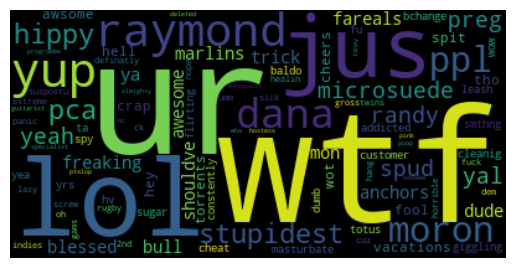

In [31]:
wordcloud = WordCloud().generate(" ".join(features[ascending_ind[:100]]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Formal WordCloud

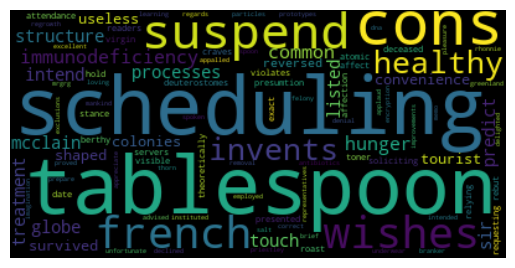

In [32]:
wordcloud = WordCloud().generate(" ".join(features[ascending_ind[-100:]]))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()